In [2]:
import numpy as np

from matplotlib import pyplot as plt

In [3]:
def centre_transform(T, origin):
    T1 = np.eye(4)
    T1[0:3,3]= np.array(origin) # translation of origin to centre of image
    T2 = np.linalg.inv(T1) # inverse translation back to origina location

    centred_transform = np.dot(T1, np.dot( T , T2 ))
    centred_transform[0:3, 3] += T[0:3, 3]
    return centred_transform

def get_transform(T, origin):

    THom = np.eye(4)

    THom[0,3] = T[0]
    THom[1,3] = T[1]
    THom[2,3] = T[2]

    # defining rotation in x
    theta_x = T[3] * np.pi /180
    rotX = np.eye(4)
    if theta_x != 0:
        rotX[1, 1] = np.cos(theta_x)
        rotX[2, 2] = np.cos(theta_x)
        rotX[2, 1] = np.sin(theta_x)
        rotX[1, 2] = -np.sin(theta_x)

    # defining rotation in y
    theta_y = T[4] * np.pi /180
    rotY = np.eye(4)
    if theta_y != 0:
        rotY[0, 0] = np.cos(theta_y)
        rotY[2, 2] = np.cos(theta_y)
        rotY[0, 2] = np.sin(theta_y)
        rotY[2, 0] = -np.sin(theta_y)

    # defining rotation in z
    theta_z = T[5] * np.pi /180
    rotZ = np.eye(4)
    if theta_z != 0:
        rotZ[0, 0] = np.cos(theta_z  )
        rotZ[1, 1] = np.cos(theta_z )
        rotZ[1, 0] = np.sin(theta_z )
        rotZ[0, 1] = -np.sin(theta_z )

    # combining rotation matrices with translation to rotate around centre
    rotations = centre_transform(rotX @ rotY @ rotZ, origin)

    # scaling
    S = np.eye(4)
    if len(T)==7:
        # making 3 values at diagonals scale factor
        S = S * T[6]
        S[-1,-1] = 1
        S = centre_transform(S, origin)

    # multiplying all these matrices to get final transform
    THom = THom @ S @ rotations
    return THom

## REGISTRATION AND TRACKING OF POINTER IN CT SCAN






![img](./images/pointer_setup.png)

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display the pointer in image coordinates as we can see in the image below:

![pointer on MRI](./images/MRI_pointer.png)

The goal is therefore turning the pointer's coordinates to MRI coordinates.

Xmri = T XendP

where T are the transformations involved in turning from the pointer's point to the MRI coordinates. These transformations are the following:

T = MRI<-T<-PatRef * PatRef<-T<-Cam  * Cam<-T<-PntRef * PntRef<-T<-endP

In the following sections we will go step by step on how to go from each of these transforms

Here is an image with all the transforms:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

# ASSUMPTIONS / SETUP

1. Cancer, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the cancer but aligned in the X direction

3. pointer is touching the cancer, so the pointer and cancer have the same coordinates

4. Length of pointer is known

5. Angle of pointer is known

In [4]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc- distances from cancer to patient reference
cancer_patref_y = 50  # Yc
# Zc and Yc would be 0 as the patient reference and cancer are aligned

# 1. Point reference to camera coordinates

Here is an image of the pointer with its reference:

![pointer image](./images/pointer_image.png)
![pointer image](./images/pointer_geometry.png)

In our case, let us assume we already know what the length of the pointer is.

In [11]:
print(f'pointer length is: {pointer_length}mm' )

pointer length is: 100mm


Original pointer reference coordinates

[[  0.   0.   0.]
 [  0.   0.  50.]
 [  0.  25. 100.]
 [  0. -25. 135.]]


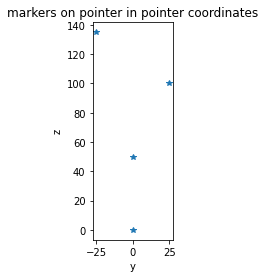

In [12]:
# pointer reference (from datasheet)
pnt_ref =  np.zeros((4, 3))
pnt_ref[1][2] = 50
pnt_ref[2][1] = 25
pnt_ref[2][2] = 100
pnt_ref[3][1] = -25
pnt_ref[3][2] = 135
print(pnt_ref)

# plotting original points
plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


TRANSFORMING TO COORDINATES FROM POINTER END

[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]
 [  0.   0.   0.]]


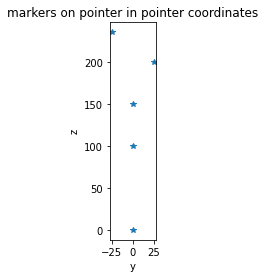

In [13]:
# adding pointer length to each coords in z direction
pnt_ref[:,2]+=pointer_length
# adding pointer end to matrix of pointer coords
pnt_tip = np.array([[0,0,0]])
pnt_ref = np.concatenate((pnt_ref, pnt_tip), axis=0)
print(pnt_ref)

plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

GENERATING 3D ROTATION

[[ 1.          0.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]]
[[  0.   0.   0.   0.   0.]
 [  0.   0.  25. -25.   0.]
 [100. 150. 200. 235.   0.]]
[[   0.          -70.71067812   70.71067812    0.        ]
 [   0.         -106.06601718  106.06601718    0.        ]
 [   0.         -123.74368671  159.09902577    0.        ]
 [   0.         -183.84776311  148.49242405    0.        ]
 [   0.            0.            0.            0.        ]]


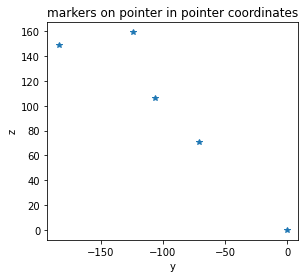

In [8]:
# setting transform and origin of rotation
T = [0,0,0,45,0,0] #([Tx, Ty, Tz, Rx, Ry, Rz])
origin = [0, 0 , 0]

# getting homogenous transformation
THom = get_transform(T,origin)
print(THom[:3, :])
print(pnt_ref.T)

# transforming with this transform
transformed_pointer = (THom[:,:3] @ pnt_ref.T).T
print(transformed_pointer)

# plotting result

plt.figure()
plt.plot(transformed_pointer[:,1],transformed_pointer[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

TRANDFORMING TO CAMERA COORDINATES

In [24]:
# turning z axis to D
transformed_pointer[0:4,3] = distance_from_cam
print(transformed_pointer)

[[   0.          -70.71067812   70.71067812 1000.        ]
 [   0.         -106.06601718  106.06601718 1000.        ]
 [   0.         -123.74368671  159.09902577 1000.        ]
 [   0.         -183.84776311  148.49242405 1000.        ]
 [   0.            0.            0.            0.        ]]


# PATIENT REFERENCE

![real patient reference](./images/real_pat_ref.png)